LeNet-300-100 with 78.9% Sparsity (Based on CIFAR-10 Success)
160 epochs: 60 pruning + 100 finetuning


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


[Pruning] Epoch: 1/160 | Train Loss: 2.6991, Train Acc: 40.11% | Val Loss: 1.2388, Val Acc: 56.24% | Sparsity: 0.013
[Pruning] Epoch: 11/160 | Train Loss: 0.2825, Train Acc: 91.31% | Val Loss: 0.3326, Val Acc: 90.17% | Sparsity: 0.145
[Pruning] Epoch: 21/160 | Train Loss: 0.2291, Train Acc: 93.13% | Val Loss: 0.2219, Val Acc: 93.14% | Sparsity: 0.276
[Pruning] Epoch: 31/160 | Train Loss: 0.2046, Train Acc: 93.81% | Val Loss: 0.1989, Val Acc: 93.76% | Sparsity: 0.408
[Pruning] Epoch: 41/160 | Train Loss: 0.1819, Train Acc: 94.32% | Val Loss: 0.1704, Val Acc: 95.29% | Sparsity: 0.539
[Pruning] Epoch: 51/160 | Train Loss: 0.1642, Train Acc: 94.94% | Val Loss: 0.1658, Val Acc: 95.11% | Sparsity: 0.671
[Finetuning] Epoch: 61/160 | Train Loss: 0.1525, Train Acc: 95.22% | Val Loss: 0.1503, Val Acc: 95.18% | Sparsity: 0.789
[Finetuning] Epoch: 71/160 | Train Loss: 0.1336, Train Acc: 95.82% | Val Loss: 0.1437, Val Acc: 95.71% | Sparsity: 0.789
[Finetuning] Epoch: 81/160 | Train Loss: 0.1236, Tr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF downloaded successfully


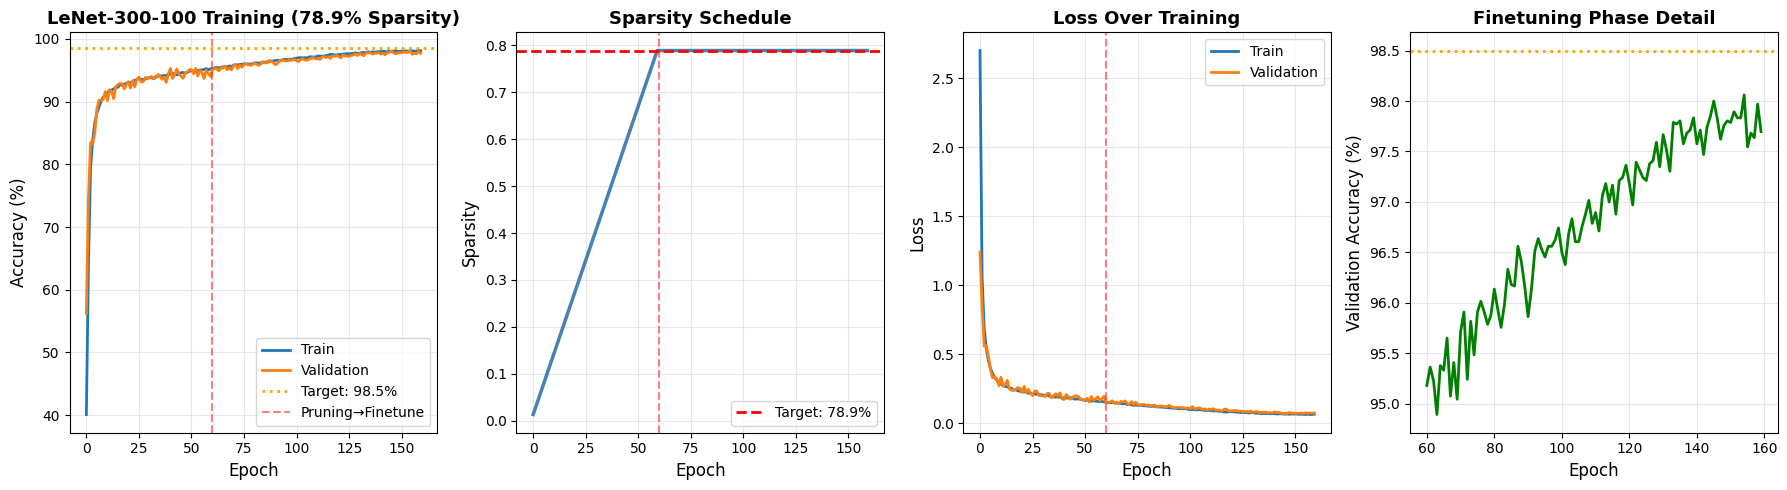

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import os

# LeNet-300-100 Architecture
class DynamicSparseLeNet300100(nn.Module):
    def __init__(self, num_classes=10):
        super(DynamicSparseLeNet300100, self).__init__()
        self.masks = {}

        # LeNet-300-100: 784 -> 300 -> 100 -> 10
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def apply_masks(self):
        """Apply masks to weights during forward pass"""
        if not hasattr(self, 'masks') or not self.masks:
            return
        with torch.no_grad():
            for name, param in self.named_parameters():
                mask = self.masks.get(name, None)
                if mask is not None:
                    param.mul_(mask)

    def forward(self, x):
        # Apply masks before forward pass
        self.apply_masks()

        x = x.view(x.size(0), -1)  # Flatten 28x28 to 784
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def initialize_weights(model):
    """Initialize weights for LeNet-300-100"""
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def apply_dynamic_supermask(model, sparsity_rate):
    """Fixed implementation with no regrowth - once pruned, stays pruned"""
    total_params = 0
    active_mags = []
    metas = []  # (name, param, current_mask)

    # Gather active weights only
    for name, param in model.named_parameters():
        if ('weight' in name) and (param.dim() > 1):
            current_mask = getattr(model, 'masks', {}).get(name, torch.ones_like(param, device=param.device))
            mags = param.detach().abs()
            active_vals = mags[current_mask.bool()]  # Only active entries
            active_mags.append(active_vals)
            metas.append((name, param, current_mask))
            total_params += param.numel()

    if not active_mags:
        return {}, 0.0

    active_cat = torch.cat(active_mags)
    # How many weights should remain nonzero globally at this sparsity
    keep_target = int(round((1.0 - sparsity_rate) * total_params))
    # Clamp to current active count
    keep_k = min(keep_target, active_cat.numel())

    if keep_k <= 0:
        thr = active_cat.max() + 1  # Prune all currently active
    else:
        thr = torch.topk(active_cat, keep_k, largest=True, sorted=True)[0][-1]

    # Build new masks with NO REGROWTH
    masks = {}
    pruned_params = 0
    for name, param, current_mask in metas:
        mags = param.detach().abs()
        new_keep = (mags >= thr).float()
        final_mask = new_keep * current_mask  # Intersect: forbids regrowth
        masks[name] = final_mask
        pruned_params += (final_mask == 0).sum().item()

    actual_sparsity = pruned_params / total_params

    # Store masks in model
    if not hasattr(model, 'masks'):
        model.masks = {}
    model.masks.update(masks)

    return masks, actual_sparsity

def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_total += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = loss_total / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def train_with_dynamic_pruning(model, train_loader, val_loader, test_loader, epochs=160, device='cuda', seed=42):
    """
    Based on successful CIFAR-10 approach, adapted for MNIST
    Reach 78.9% sparsity by epoch 60, then continue at 78.9% for 100 more epochs
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)  # Removed label smoothing for max accuracy
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    initial_sparsity = 0.0
    final_sparsity = 0.789  # 78.9% sparsity
    pruning_epochs = 60  # Reach 78.9% by epoch 60

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    sparsity_history = []

    initialize_weights(model)

    # Track training time
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Dynamic sparsity schedule: reach 78.9% by epoch 60, stay at 78.9% afterwards
        if epoch < pruning_epochs:
            current_sparsity = initial_sparsity + (final_sparsity - initial_sparsity) * ((epoch + 1) / pruning_epochs)
        else:
            current_sparsity = final_sparsity

        masks, actual_sparsity = apply_dynamic_supermask(model, current_sparsity)
        sparsity_history.append(actual_sparsity)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Apply masks to gradients
            for name, param in model.named_parameters():
                if name in masks and param.grad is not None:
                    param.grad.mul_(masks[name])

            optimizer.step()

            # Re-enforce masks post-step
            with torch.no_grad():
                for name, param in model.named_parameters():
                    mask = model.masks.get(name, None)
                    if mask is not None:
                        param.mul_(mask)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_accuracy = 100.0 * correct / total

        # Validation
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        scheduler.step()

        if epoch % 10 == 0 or epoch == epochs - 1 or epoch == pruning_epochs:
            phase = "Pruning" if epoch < pruning_epochs else "Finetuning"
            print(
                f"[{phase}] Epoch: {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
                f"Sparsity: {actual_sparsity:.3f}"
            )

    training_time = time.time() - start_time

    # Final evaluation
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'sparsity_history': sparsity_history,
        'training_time': training_time,
        'final_sparsity': actual_sparsity
    }

    return results

if __name__ == "__main__":
    print("="*70)
    print("LeNet-300-100 with 78.9% Sparsity (Based on CIFAR-10 Success)")
    print("160 epochs: 60 pruning + 100 finetuning")
    print("="*70)

    # Set seed
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Data setup - simpler augmentation for MNIST
    transform_train = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_size = int(0.89 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DynamicSparseLeNet300100(num_classes=10).to(device)

    # Train with extended epochs (following CIFAR-10 approach)
    results = train_with_dynamic_pruning(
        model, train_loader, val_loader, test_loader, epochs=160, device=device, seed=seed
    )

    print(f"\n=== Final Results ===")
    print(f"Test Accuracy: {results['test_accuracy']:.2f}% (Target: >98.5%)")
    print(f"Final Sparsity: {results['final_sparsity']:.3f}")
    print(f"Training Time: {results['training_time']:.1f}s")

    target_met = "✓ TARGET MET" if results['test_accuracy'] > 98.5 else "✗ NOT MET"
    print(f"Target Status: {target_met}")

    # Plot results
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.plot(results['train_acc'], label='Train', linewidth=2)
    plt.plot(results['val_acc'], label='Validation', linewidth=2)
    plt.axhline(y=98.5, color='orange', linestyle=':', linewidth=2, label='Target: 98.5%')
    plt.axvline(x=60, color='red', linestyle='--', alpha=0.5, label='Pruning→Finetune')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('LeNet-300-100 Training (78.9% Sparsity)', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 2)
    plt.plot(results['sparsity_history'], linewidth=2.5, color='steelblue')
    plt.axhline(y=0.789, color='r', linestyle='--', linewidth=2, label='Target: 78.9%')
    plt.axvline(x=60, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Sparsity', fontsize=12)
    plt.title('Sparsity Schedule', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 3)
    plt.plot(results['train_losses'], label='Train', linewidth=2)
    plt.plot(results['val_losses'], label='Validation', linewidth=2)
    plt.axvline(x=60, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Loss Over Training', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 4)
    # Show last 100 epochs of validation accuracy (finetuning phase)
    plt.plot(range(60, 160), results['val_acc'][60:], linewidth=2, color='green')
    plt.axhline(y=98.5, color='orange', linestyle=':', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title('Finetuning Phase Detail', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save to current directory (works in Colab and local)
    save_path = 'lenet_789_sparsity_results.pdf'
    plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight')
    print(f"\n✓ Plots saved to {save_path}")

    # For Google Colab - auto download
    try:
        from google.colab import files
        files.download(save_path)
        print("PDF downloaded successfully")
    except:
        print(f"PDF saved locally at: {os.path.abspath(save_path)}")

    plt.show()